# Задание 11. Сравнение различных подходов к распределению итераций циклов между потоками
Цель данного задания - сравнить имеющиеся в openmp способы распределения данных между потоками, а именно:
- `static`
- `dynamic`
- `guided`

Для того чтобы все итерации цикла требовали разной вычислительной нагрузки в теле цикла вызывается следующий метод:
```c
static int testIteration(int number)
{
    if (number % 10 == 0)
    {
        return GetRandomInteger(-1000, 1000);
    }

    return number;
}
```
Он либо возвращает `number`,  либо находит случайное число в диапазоне от -1000 до 1000.


## Описание подходов
Все описанные методы находятся в модуле [`differentCycleModes`](../../differentCycleModes/differentCycleModes.c).

### Однопоточная версия

```c
static int plainForLoop(int numIterations)
{
    int sumMod = 0;
    for (int i = 0; i < numIterations; i++)
    {
        sumMod += testIteration(i) % 100;
    }
    return sumMod;
}
```

### Static распределение


```c
static int staticScheduledForLoop(int numIterations)
{
    int sumMod = 0;
#pragma omp parallel for shared(numIterations) schedule(static, 8) reduction(+ \
                                                                             : sumMod)
    for (int i = 0; i < numIterations; i++)
    {
        sumMod += testIteration(i) % 100;
    }
    return sumMod;
}
```

### Dynamic распределение
```c
static int dynamicScheduledForLoop(int numIterations)
{
    int sumMod = 0;
#pragma omp parallel for shared(numIterations) schedule(dynamic, 8) reduction(+ \
                                                                              : sumMod)

    for (int i = 0; i < numIterations; i++)
    {
        sumMod += testIteration(i) % 100;
    }
    return sumMod;
}
```

### Guided распределение
```c
static int guidedScheduledForLoop(int numIterations)
{
    int sumMod = 0;
#pragma omp parallel for shared(numIterations) schedule(guided) reduction(+ \
                                                                          : sumMod)
    for (int i = 0; i < numIterations; i++)
    {
        sumMod += testIteration(i) % 100;
    }
    return sumMod;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы на циклах из 100, 10000 и 1000000 итераций. Было проведено 15 экспериментов, их результаты сохранены в файле [output.csv](../build/output.csv). 
Первые 10 строк таблицы представлены ниже.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
num_iterations = {100: "small", 10000: "medium", 1000000: "large"}
dataset = dataset.astype({'method': 'category',  'num_iterations': 'category'})
dataset['num_iterations'] = dataset['num_iterations'].replace(num_iterations)
print(dataset.head(10))


   num_threads   method num_iterations  elapsed_time
0            1   single          small        0.0010
1            2   static          small        0.0467
2            2  dynamic          small        0.0031
3            2   guided          small        0.0024
4            3   static          small        0.0351
5            3  dynamic          small        0.0103
6            3   guided          small        0.0028
7            4   static          small        0.0438
8            4  dynamic          small        0.0060
9            4   guided          small        0.0059


Рассчитаем среднее время работы каждого из описанных подходов для каждого количества итераций.

In [2]:
dataset.num_iterations.unique()

['small', 'medium', 'large']
Categories (3, object): ['small', 'medium', 'large']

In [3]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['num_iterations', 'elapsed_time']].groupby('num_iterations').agg({'elapsed_time': 'mean'}).sort_values('num_iterations')
means_for_static = dataset[dataset['method'] == 'static'][['num_iterations', 'elapsed_time']].groupby('num_iterations').agg({'elapsed_time': 'mean'}).sort_values('num_iterations')
means_for_dynamic = dataset[dataset['method'] == 'dynamic'][['num_iterations', 'elapsed_time']].groupby('num_iterations').agg({'elapsed_time': 'mean'}).sort_values('num_iterations')
means_for_guided = dataset[dataset['method'] == 'guided'][['num_iterations', 'elapsed_time']].groupby('num_iterations').agg({'elapsed_time': 'mean'}).sort_values('num_iterations')

In [4]:
def visualize(ylabel, title, data):
    labels = num_iterations.keys()
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['single'],
                    width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['static'],
                    width, label='Многопоточная со статическим распределением')
    rects3 = ax.bar(x + width/2, data['dynamic'], width,
                    label='Многопоточная с динамическим распределением')
    rects4 = ax.bar(x + 3*width/2, data['guided'],
                    width, label='Многопоточная с управляемым распределением')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого количества итераций. 

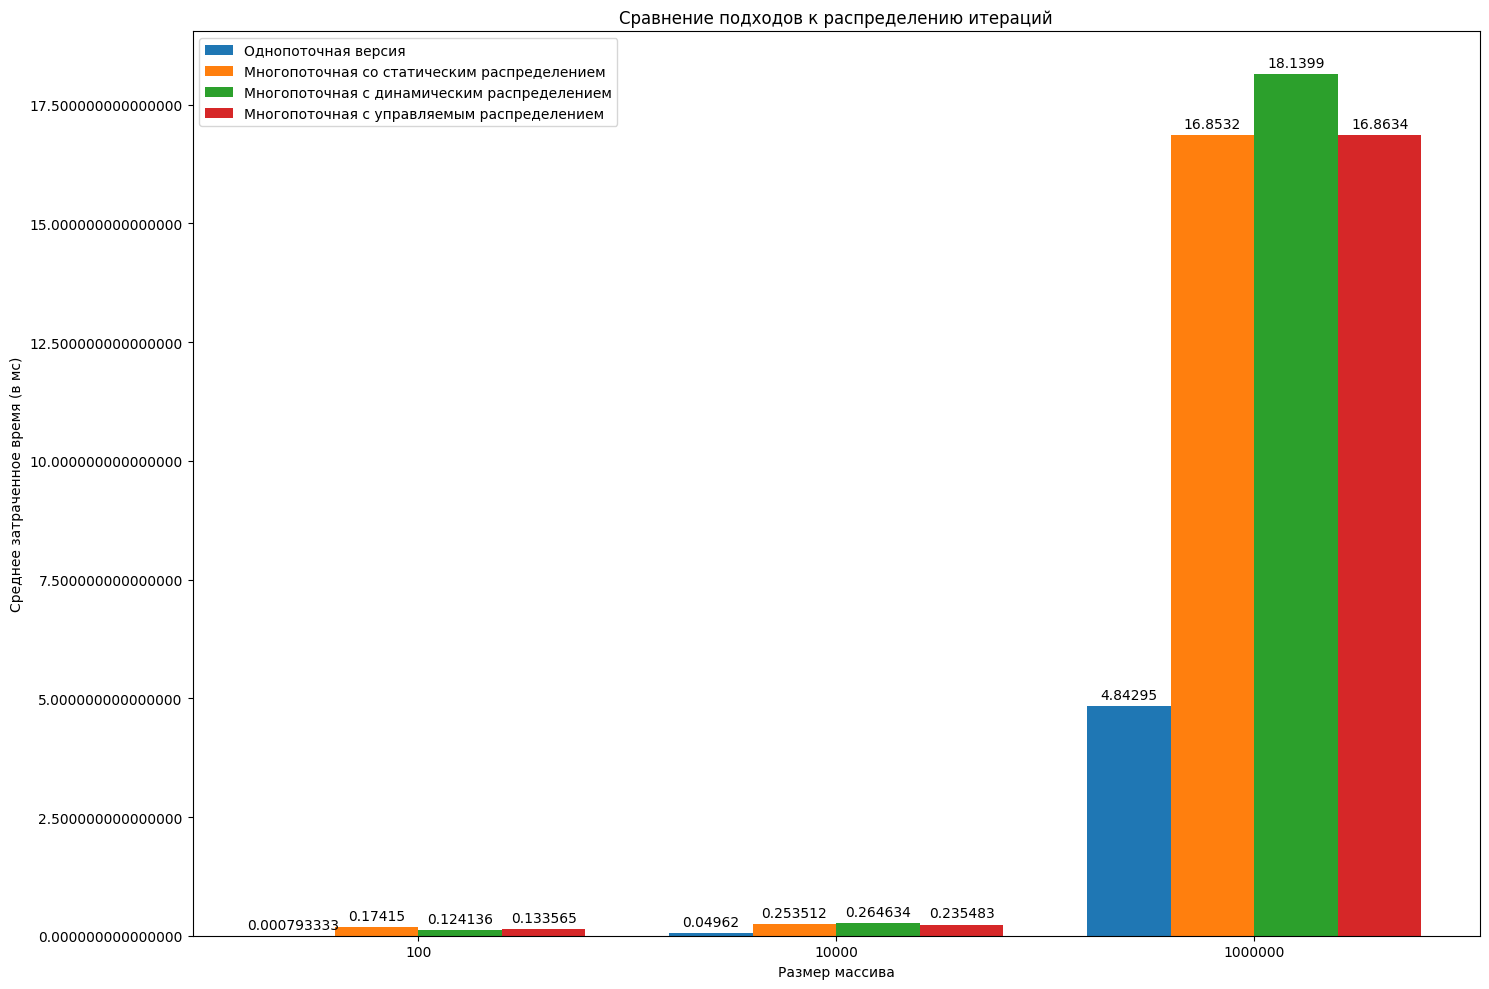

In [5]:
mean_data = {
    "single":  means_for_single_thread['elapsed_time'],
    "static": means_for_static['elapsed_time'],
    "dynamic":  means_for_dynamic['elapsed_time'],
    "guided": means_for_guided['elapsed_time']
}

visualize('Среднее затраченное время (в мс)',
          'Сравнение подходов к распределению итераций', mean_data)


Как мы можем заметить, для любого количества итераций однопоточный алгоритм оказывается эффективнее. Тем не менее, сравним оставшиеся алгоритмы и посмотрим, какой из них оказывается наиболее эффективным.

In [6]:
means_for_single_thread = dataset[dataset['method'] == 'single'].groupby(
    'num_iterations').agg({'elapsed_time': 'mean'}).reset_index()

means_for_multhread = dataset[dataset['num_threads'] >= 2].groupby(
    ['num_threads', 'num_iterations', 'method']).agg({'elapsed_time': 'mean'})
means_for_multhread = means_for_multhread[means_for_multhread['elapsed_time'].notnull(
)].reset_index()


smtet = means_for_multhread[means_for_multhread['num_iterations']
                            == 'small']['elapsed_time']
sstet = means_for_single_thread[means_for_single_thread['num_iterations']
                                == 'small']['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_iterations']
                        == 'small', 'boost'] = sstet.loc[0]/ smtet 

mmtet = means_for_multhread[means_for_multhread['num_iterations']
                            == 'medium']['elapsed_time']
mstet = means_for_single_thread[means_for_single_thread['num_iterations']
                                == 'medium']['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_iterations']
                        == 'medium', 'boost'] = mstet.loc[1] / mmtet 

lmtet = means_for_multhread[means_for_multhread['num_iterations']
                            == 'large']['elapsed_time']
lstet = means_for_single_thread[means_for_single_thread['num_iterations']
                                == 'large']['elapsed_time']
means_for_multhread.loc[means_for_multhread['num_iterations']
                        == 'large', 'boost'] = lstet.loc[2] / lmtet 

In [7]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_static = plt.plot(
        x, data.loc[filters['static'], 'boost'], label='Статическое распределение')
    bfsa_dynamic = plt.plot(
        x, data.loc[filters['dynamic'], 'boost'], label='Динамическое распределение')
    bfsa_guided = plt.plot(
        x, data.loc[filters['guided'], 'boost'], label='Управляемое распределение')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()
        

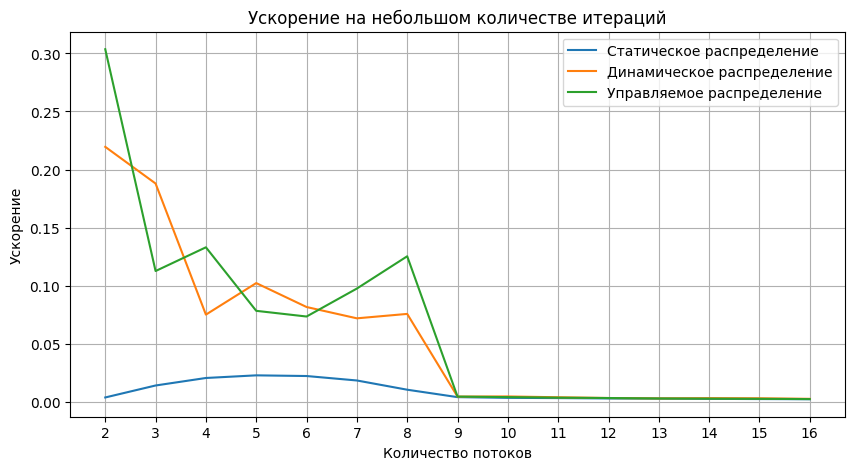

In [8]:
filters_for_small_iterations = {
    'static': (means_for_multhread['method'] == 'static') & (means_for_multhread['num_iterations'] == 'small'),
    'guided': (means_for_multhread['method'] == 'guided') & (means_for_multhread['num_iterations'] == 'small'),
    'dynamic': (means_for_multhread['method'] == 'dynamic') & (means_for_multhread['num_iterations'] == 'small')
}
visualize_boost(means_for_multhread, filters_for_small_iterations, 'Ускорение на небольшом количестве итераций')

На небольшом количестве итераций статическое распределенин показало наихудший результат. Лучше всего отработало управляемое распределение при 2 потоках.

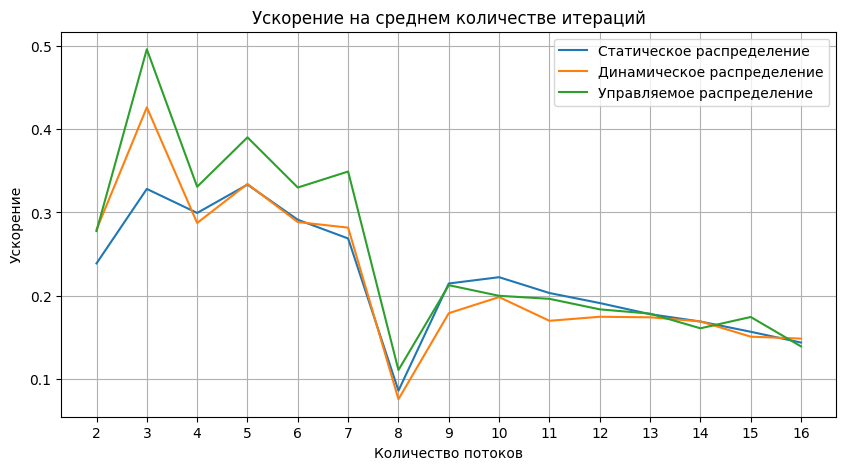

In [9]:
filters_for_medium_iterations = {
    'static': (means_for_multhread['method'] == 'static') & (means_for_multhread['num_iterations'] == 'medium'),
    'guided': (means_for_multhread['method'] == 'guided') & (means_for_multhread['num_iterations'] == 'medium'),
    'dynamic': (means_for_multhread['method'] == 'dynamic') & (means_for_multhread['num_iterations'] == 'medium')
}
visualize_boost(means_for_multhread, filters_for_medium_iterations, 'Ускорение на среднем количестве итераций')

Для среднего количества итераций ситуация все выглядит лучше. Однако управляемое распределение все так же остается наиболее оптимальным, а статическое - наименее оптимальным.

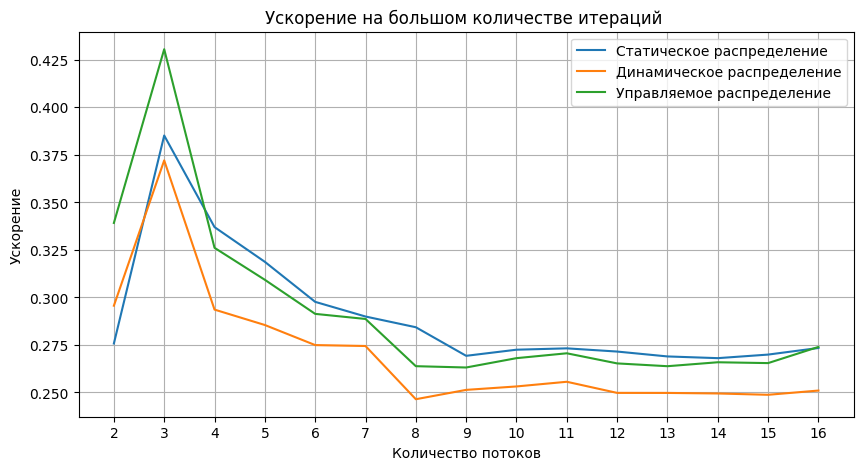

In [10]:
filters_for_large_iterations = {
    'static': (means_for_multhread['method'] == 'static') & (means_for_multhread['num_iterations'] == 'large'),
    'guided': (means_for_multhread['method'] == 'guided') & (means_for_multhread['num_iterations'] == 'large'),
    'dynamic': (means_for_multhread['method'] == 'dynamic') & (means_for_multhread['num_iterations'] == 'large')
}
visualize_boost(means_for_multhread, filters_for_large_iterations,
                'Ускорение на большом количестве итераций ')


Для большого количества итераций картина несколько меняется. Управляемое распределение все так же остается наиболее оптимальным способом, однако на втором месте теперь находится статическое распределение.